# Question 1

from static replication of CMS in part 3. Update $g(K)$

$$
g(K) = K^{\frac{1}{p}} - 0.04^{\frac{1}{q}} \quad \quad 
g'(K) = \frac{1}{p} K^{\frac{1}{p} - 1} \quad \quad 
g''(K) = \left( \frac{1}{p} - 1 \right) \left( \frac{1}{p} \right) K^{\frac{1}{p}-2}
$$

## Imports and data wrangling

OIS is in semiannual df. need to also include for quarterly period

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.stats import norm
from scipy.interpolate import interp1d

ois = pd.read_csv('./data/ois.csv')     # load discounting curve
fsr = pd.read_csv('./data/sabr_params.csv')     # load discounting curve
irs = pd.read_csv('./data/irs.csv')             # load par swap rates
# get df for quarterly payments using zero rates
new_expiry = np.arange(0.25, ois["years"].max() + 0.25, 0.25)
ois = ois.set_index("years").reindex(new_expiry)
ois["f"] = ois["f"].bfill() 
ois = ois.ffill()
ois.reset_index(inplace=True)
ois.rename(columns={"index": "years"}, inplace=True)
ois["df"] = ois.apply(lambda row: 1 / ((1 + row['f'] / 360) ** (90)), axis=1)
ois["df_cumprod"] = ois["df"].cumprod()

In [59]:
## IRR funcions
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative
# Payoff functions
def g_0(K, p, q):
    return K ** (1/p) - 0.04 ** (1/q)

def g_1(K, p):
    return 1/p * K ** (1/p - 1)

def g_2(K, p):
    return (1/p - 1) * 1 / p * K ** (1/p - 2)

def h_0(K, m, N, p, q):
    # implementation of h(K)
    value = g_0(K, p, q) / IRR_0(K, m, N)
    return value

def h_1(K, m, N, p, q):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K, p) - g_0(K, p, q)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N, p, q):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K, p) - IRR_2(K, m, N)*g_0(K, p, q) - 2.0*IRR_1(K, m, N)*g_1(K, p))/IRR_0(K, m, N)**2 
                        + 2.0*IRR_1(K, m, N)**2*g_0(K, p, q)/IRR_0(K, m, N)**3)
    return secondDerivative
    
def black76_pay(F, K, expiry, tenor, sigma):
    """
    Return value of payer swaption via Black Normal model only
    parameters
        F: forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = F * norm.cdf(d_1) - K * norm.cdf(d_2)
    return black_option
    
def black76_rec(F, K, expiry, tenor, sigma):
    """
    Return value of receiver swaption via Black Normal model Only
    parameters
        F: Forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = K * norm.cdf(-d_2) - F * norm.cdf(-d_1)
    return black_option

def SABR(F, K, T, alpha, rho, nu, beta=0.9):
    """
    Use SABR model to return sigma, set beta to be 0.9
    """
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

# Carr-Madan Breeden-Litzenberger model free functions
def rec_integrand(F, K, expiry, tenor, alpha, rho, nu, m, p, q):
    """
    Return value of receiver integrand per CMS rate payoff. 
    formula: 2nd derivative h * V_rec(per SABR valuation) 
    parameters:
        m: payment freq per year, e.g. 2 is semi-annual
        F: par swap rate
        K: strike of CMS
        expiry: years to expiry of swaption
        tenor: tenor of underlying swap
        alpha: SABR param
        rho: SABR param
        nu: SABR param
    """
    sigma_sabr = SABR(F, K, expiry, alpha, rho, nu, beta=0.9)
    sabr_pricing = black76_rec(F, K, expiry, tenor, sigma_sabr)
    return h_2(K, m, tenor, p, q) * sabr_pricing

def pay_integrand(F, K, expiry, tenor, alpha, rho, nu, m, p, q):
    """
    Return value of receiver integrand per CMS rate payoff. 
    formula: 2nd derivative h * V_rec(per SABR valuation) 
    parameters:
        m: payment freq per year, e.g. 2 is semi-annual
        F: par swap rate
        K: strike of CMS
        expiry: years to expiry
        tenor: tenor of underlying swap
        alpha: SABR param
        rho: SABR param
        nu: SABR param
    """
    sigma_sabr = SABR(F, K, expiry, alpha, rho, nu, beta=0.9)
    sabr_pricing = black76_pay(F, K, expiry, tenor, sigma_sabr)
    return h_2(K, m, tenor, p, q) * sabr_pricing

def v_0_exotic(F, expiry, tenor, alpha, rho, nu, m, p, q):
    """
    Return forward CMS single coupon payoff based of static replication discounted to today's price. Uses SABR model
    for exotic payoff g(K) = K^{\frac{1}{p}} - 0.04^{\frac{1}{q}}
    parameters:
        F: par swap rate for given tenor
        expiry: swaption time to expiry
        tenor: underlying swap tenor
        alpha, rho, nu: SABR pricing model params
        m: underlying swap payment frequency per year
    """
    df_expiry = ois.loc[ois.years == expiry]['df'].values[0]
    int_1 = IRR_0(F, m, tenor) * quad(lambda x: rec_integrand(F, x, expiry, tenor, alpha, rho, nu, m, p, q), 0.0, F)[0]
    int_2 = IRR_0(F, m, tenor) * quad(lambda x: pay_integrand(F, x, expiry, tenor, alpha, rho, nu, m, p, q), F, 100_000_000)[0]

    return df_expiry * F + int_1 + int_2

def v_0_exotic_caplet(F, expiry, tenor, alpha, rho, nu, m, p, q):
    """
    Return forward CMS single coupon payoff based of static replication discounted to today's price. Uses SABR model
    for exotic payoff g(K) = K^{\frac{1}{p}} - 0.04^{\frac{1}{q}}
    parameters:
        F: par swap rate for given tenor
        expiry: swaption time to expiry
        tenor: underlying swap tenor
        alpha, rho, nu: SABR pricing model params
        m: underlying swap payment frequency per year
    """
    df_expiry = ois.loc[ois.years == expiry]['df'].values[0]

    if F > 0.04**(1/q):
        int_1 = IRR_0(F, m, tenor) * quad(lambda x: rec_integrand(F, x, expiry, tenor, alpha, rho, nu, m, p, q), 0.04**(1/q), F)[0]
        int_2 = IRR_0(F, m, tenor) * quad(lambda x: pay_integrand(F, x, expiry, tenor, alpha, rho, nu, m, p, q), F, 100_000_000)[0]
    else:
        int_1 = 0
        int_2 = IRR_0(F, m, tenor) * quad(lambda x: pay_integrand(F, x, expiry, tenor, alpha, rho, nu, m, p, q), 0.04**(1/q), 100_000_000)[0]

    return df_expiry * F + int_1 + int_2



### CMS10y for 5 year exotic payoff

In [60]:
expiry = 5
maturity = 10
p, q = 4, 2

F = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['f_irs'].values[0]
alpha = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['alpha'].values[0]
rho = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['rho'].values[0]
nu = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['nu'].values[0]
m = 2       # forward libor is in semi-annual payments, assume the same for CMS

v_0_exotic(F, expiry, maturity, alpha, rho, nu, m, p, q)

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_69775/1618695267.py:149: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_1 = IRR_0(F, m, tenor) * quad(lambda x: rec_integrand(F, x, expiry, tenor, alpha, rho, nu, m, p, q), 0.0, F)[0]


0.02422933074070596

### CMS10y for 5 year exotic caplet payoff

In [61]:
v_0_exotic_caplet(F, expiry, maturity, alpha, rho, nu, m, p, q)

0.04885131348275907

payoff function is not well behaved. as seen by second derivative of payoff function,
$$
g''(K) = \left( \frac{1}{p} - 1 \right) \left( \frac{1}{p} \right) K^{\frac{1}{p}-2}
$$

the payoff function is strictly increasing so when it cannot be integrate to a definite value

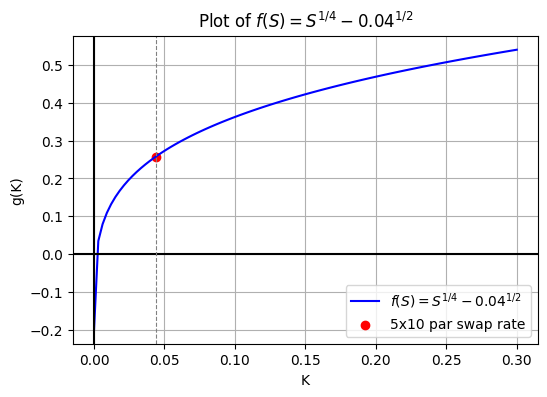

In [62]:
def f(x):
    return x**(1/4) - 0.04**(1/2)

x_vals = np.linspace(0, 0.3, 100)
y_vals = f(x_vals)
x_point = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['f_irs'].values[0]
y_point = f(x_point)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, label=r"$f(S) = S^{1/4} - 0.04^{1/2}$", color="b")
plt.scatter(x_point, y_point, color="r", label=f"5x10 par swap rate")
plt.axhline(0, color="black", linewidth=1.5)
plt.axvline(0, color="black", linewidth=1.5) 
plt.axvline(x_point, color="gray", linestyle="--", linewidth=0.8)

# Labels
plt.xlabel("K")
plt.ylabel("g(K)")
plt.title("Plot of $f(S) = S^{1/4} - 0.04^{1/2}$")
plt.legend()
plt.grid()
plt.show()